In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


In [4]:
#variables 
seed=1161
N_train= int(201)
N_test= int(101)
K_vals= np.arange(1, 61)   # k = 1 - 60
N_fold= 5 #for cross validation 

In [5]:
#Equation for optimal curve for generating set 
def f_opt(x):
    return np.sin(2.0 * np.pi * x)

In [6]:
#calculate the RMSE 
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true-y_pred)**2)))

In [7]:
#Generate the test and training set 
def generate_sets(seed, N_train, N_test):
    x_tr= np.linspace(0, 1, N_train)
    x_te=np.linspace(0, 1, N_test)
    np.random.randn(seed)
    t_tr= f_opt(x_tr) + 0.2*np.random.randn(N_train)
    t_te= f_opt(x_te) + 0.2*np.random.randn(N_test)
    return x_tr, t_tr, x_te, t_te

In [8]:
def euclidean_distance(x1, x2):
    # x1, x2 =scalars
    return float(np.sqrt((x1 - x2)**2))

In [9]:
def eu_distances(x_te, x_tr):
    # accept (N,1) so make sure that the shape is .reshape(-1,1) to get the intuitive shape so this doesnt fail
    #.ndim calculates the dimension to make sure its a 1D array because of errors 
    if x_te.ndim == 1: 
        x_te = x_te.reshape(-1, 1)
    if x_tr.ndim == 1: 
        x_tr = x_tr.reshape(-1, 1)

    #sizes
    n_test, n_train = x_te.shape[0], x_tr.shape[0]
    #create matrix for distances
    D = np.zeros((n_test, n_train), dtype=float)
    #
    for i in range(n_test):
        xi = x_te[i, 0]
        for j in range(n_train):
            xj = x_tr[j, 0]
            D[i, j] = np.abs(xi - xj)  # same as sqrt((xi-xj)**2) gets absolute values 
    return D

In [10]:
def y_pred(Nk_test, k, distances, t_tr):
    
    #distances: (Nk_test, Nk_train) matrix
    #For each row i, pick k smallest distances and average t_tr of those neighbors.
    
    y = np.zeros((Nk_test,), dtype=float)
    for i in range(Nk_test):
        #argpartition 
        # k-nearest indices for row i tried to use partition for better time but couldnt get it to work come back to this  
        #nn_idx = np.argpartition(distances[i], k-1)[:k]  

        # Sort the distances for the i-th test point and take indices of k nearest points
        nn_idx = np.argsort(distances[i])[:k] 
        # Average the target values of those k nearest neighbors
        y[i] = np.mean(t_tr[nn_idx]) #get mean of the row 
    return y

In [11]:
def shift (x_tr, t_tr, n):
    #x is the array. it is the size of x_test because that is the size of the split for test 
    x_tr = np.roll(x_tr, n)
    t_tr = np.roll(t_tr, n)
    return x_tr, t_tr

In [26]:
def main():
    # generate data
    x_tr, t_tr, x_te, t_te = generate_sets(seed, N_train, N_test)
    #reshaping to prevent error in functions 
    if x_tr.ndim == 1: 
        x_tr= x_tr.reshape(-1, 1)
    if x_te.ndim == 1:
        x_te= x_te.reshape(-1, 1)

    # rmse
    size_k = len(K_vals)
    D_train = eu_distances(x_tr, x_tr) #get distances from query to training 
    rmse_train = np.empty(size_k, dtype=float) 
    #get index=1, k val=k so can do 2 things at once
    for i, k in enumerate(K_vals):
        yhat_tr = y_pred(x_tr.shape[0], k, D_train, t_tr)# training pred
        rmse_train[i] = rmse(t_tr, yhat_tr)#appedn to the rmse array

    #k fold the data -> 0.2 is 5 fold since 20% of the data set 
    X_tr_f, X_va_f, t_tr_f, t_va_f = train_test_split(x_tr, t_tr, test_size=0.2, random_state=seed, shuffle=True)
    rmse_val = np.empty(size_k, dtype=float)#rmse for k fold
    for i, k in enumerate(K_vals):
        #use knn in k-fold do same thing as above
        D_val = eu_distances(X_va_f, X_tr_f) #get from query point to the 
        yhat_val = y_pred(X_va_f.shape[0], k, D_val, t_tr_f)
        rmse_val[i] = rmse(t_va_f, yhat_val)

    D_test = eu_distances(x_te, x_tr)

    rmse_test_curve = np.empty(size_k, dtype=float)
    for i, k in enumerate(K_vals):
        yhat_te_k = y_pred(x_te.shape[0], k, D_test, t_tr)
        rmse_test_curve[i] = rmse(t_te, yhat_te_k)
    
    # test error at the chosen k (picked from CV, not from test!)
    best_idx = int(np.argmin(rmse_val))
    k_best = int(K_vals[best_idx])
    test_rmse = rmse_test_curve[best_idx]
    # evalatue the best k against the test data 
    best_idx= int(np.argmin(rmse_val))#best index is the argmin of the rmse_val this gives k index for lowest val
    k_best= int(K_vals[best_idx])


    
#add grid layout 
    # rmse vs k 
    plt.figure(figsize=(8,5))
    plt.plot(K_vals, rmse_train, marker='o', label='Training RMSE')
    plt.plot(K_vals, rmse_val, marker='s',label='5-fold CV MSE')
    plt.plot(K_vals, rmse_test_curve, marker='^', label='Test RMSE')
    plt.scatter([k_best], [rmse_val[best_idx]], s=90, zorder=4, label=f'Best k = {k_best}')
    plt.xlabel('k (number of neighbours)'); plt.ylabel('RMSE')
    plt.title('Training vs 5-fold CV Error across k')
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # best k predictor graph 
    #use .ravel to make things 1d array no error
    
    xx = np.linspace(0, 1, 400).reshape(-1, 1) #make x margin
    D_xx = eu_distances(xx, x_tr) # distances to training set
    yhat_xx = y_pred(xx.shape[0], k_best, D_xx, t_tr) # k-NN curve at best k

    plt.figure(figsize=(8,5))
    plt.scatter(x_tr.ravel(), t_tr, s=12, alpha=0.7, label='Train')
    plt.scatter(x_te.ravel(), t_te, s=12, alpha=0.7, label='Test')
    plt.plot(xx.ravel(), f_opt(xx.ravel()), lw=2, label='True f(x)=sin(2πx)')
    plt.plot(xx.ravel(), yhat_xx, lw=2, label=f'k-NN (k={k_best})')

    plt.xlabel('x'); plt.ylabel('t / prediction')
    plt.title('Final Predictor vs True Function and Data')
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


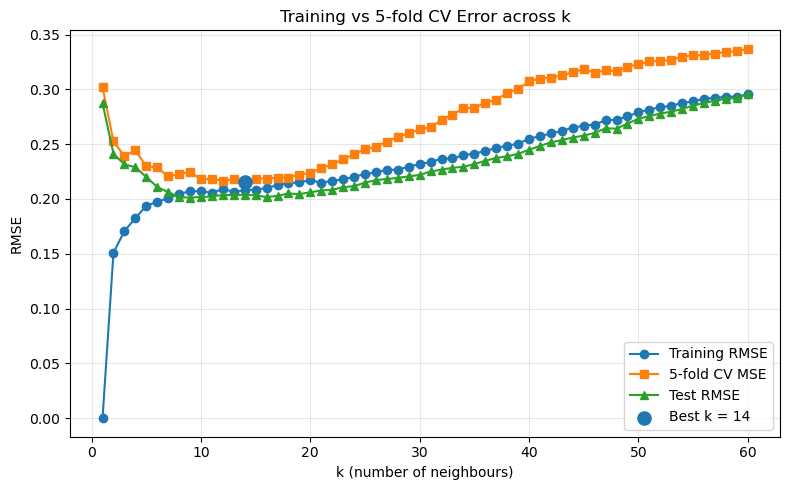

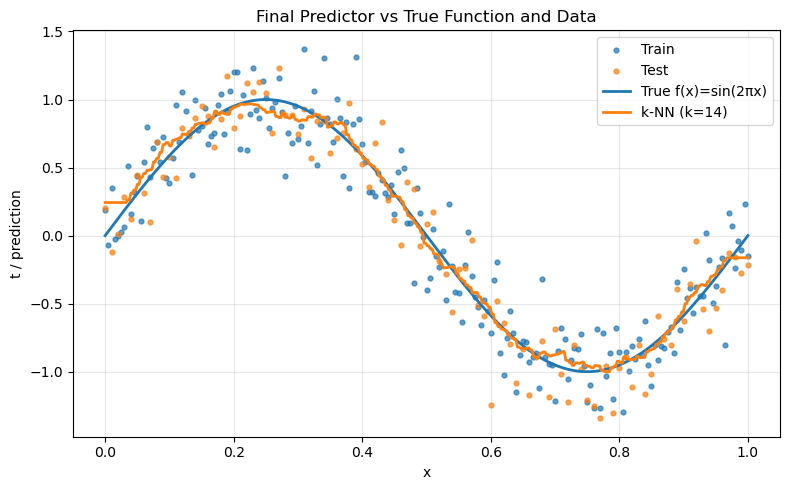

In [27]:
main()